In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.path import Path
import json
import zipfile
import io
import os
#import utm

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Legend, ColumnDataSource, Title
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.models import GeoJSONDataSource
from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

In [2]:
np.random.seed(42)

In [5]:
if not os.path.exists("data/2016"):
    r = requests.get("https://datos.madrid.es/egob/catalogo/208627-32-transporte-ptomedida-historico.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    os.mkdir("data/2016")
    z.extractall("data/2016/")

In [7]:
jan_2016 = pd.read_csv("data/2016/01-2016.csv", sep=";")
jan_2016.head()

,idelem,fecha,identif,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,3581,2016-01-01 09:15:00,61079,PUNTOS MEDIDA URBANOS,40,0,0,0,N,1
1,3982,2016-01-01 00:00:00,06042,PUNTOS MEDIDA URBANOS,52,0,2,0,N,13
2,4291,2016-01-01 09:15:00,16013,PUNTOS MEDIDA URBANOS,43,4,12,0,N,7
3,4200,2016-01-01 09:15:00,14002,PUNTOS MEDIDA URBANOS,52,0,4,0,N,14
4,5928,2016-01-01 09:15:00,44030,PUNTOS MEDIDA URBANOS,124,0,6,0,N,13


In [8]:
len(jan_2016)

10570682

In [9]:
jan_2016["idelem"].unique().shape

(3797,)

In [10]:
if not os.path.exists("data/traffic_points"):
    r = requests.get("https://datos.madrid.es/egob/catalogo/202468-2-intensidad-trafico.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    os.mkdir("data/traffic_points")
    z.extractall("data/traffic_points/")

In [11]:
def from_latlon(lat, lon):
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale

    return x, y

def get_lat_lon_utm(row):

    # 30 and 'T' is the zone of Madrid
    lat, lon = utm.to_latlon(row["st_x"], row["st_y"], 30, "T")
    
    x, y = from_latlon(lat, lon)

    return pd.Series([lat, lon, x, y])

In [12]:
traffic_points = pd.read_csv("shared_data/traffic_points/pmed_trafico_03052016.csv", sep=";")

traffic_points[["latitude", "longitude", "utm_x", "utm_y"]] = traffic_points.apply(get_lat_lon_utm, axis=1)

traffic_points.head()

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y
0,1044,494,03FT08PM01,03FT08PM01,438963.314635,4.474734e+06,40.421001,-3.719488,-414051.481782,4.927311e+06
1,3600,494,PM30901,PM30901,443729.047369,4.473268e+06,40.408129,-3.663184,-407783.811885,4.925429e+06
2,3705,494,PM41451,PM41451,439858.261097,4.471574e+06,40.392598,-3.708640,-412843.963659,4.923159e+06
3,6823,494,PM41453,PM41453,439188.095183,4.470895e+06,40.386431,-3.716471,-413715.710072,4.922257e+06
4,7033,495,01015,Pº Castellana S-N - Pl. Colon-Hermosilla,441569.555897,4.475502e+06,40.428107,-3.688839,-410639.639249,4.928350e+06


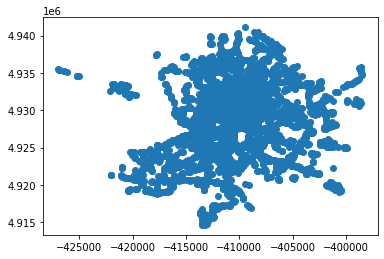

In [13]:
plt.scatter(traffic_points["utm_x"], traffic_points["utm_y"])

In [14]:
with open("shared_data/districts/districts.geojson", "r") as geojson:
    geodata = json.load(geojson)

In [15]:
g_data = pd.DataFrame(geodata["features"][0]["geometry"]["coordinates"][0], columns=["st_x", "st_y"])
g_data[["latitude", "longitude", "utm_x", "utm_y"]] = g_data.apply(get_lat_lon_utm, axis=1)
g_data.head()

,st_x,st_y,latitude,longitude,utm_x,utm_y
0,441184.784,4473200.78,40.407345,-3.693162,-411120.867401,4.925314e+06
1,441181.244,4473184.23,40.407196,-3.693202,-411125.341089,4.925293e+06
2,441178.884,4473160.91,40.406986,-3.693227,-411128.197118,4.925262e+06
3,441140.854,4473176.92,40.407127,-3.693677,-411178.251532,4.925282e+06
4,441126.355,4473191.33,40.407256,-3.693849,-411197.420454,4.925301e+06


In [16]:
path = Path(g_data[["utm_x", "utm_y"]].values)
points = traffic_points[["utm_x", "utm_y"]].values

points_in_path_mask = path.contains_points(points)

traffic_points["color"] = "red"

traffic_points.loc[points_in_path_mask, "color"] = "blue"
traffic_points.head()

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y,color
0,1044,494,03FT08PM01,03FT08PM01,438963.314635,4.474734e+06,40.421001,-3.719488,-414051.481782,4.927311e+06,red
1,3600,494,PM30901,PM30901,443729.047369,4.473268e+06,40.408129,-3.663184,-407783.811885,4.925429e+06,red
2,3705,494,PM41451,PM41451,439858.261097,4.471574e+06,40.392598,-3.708640,-412843.963659,4.923159e+06,red
3,6823,494,PM41453,PM41453,439188.095183,4.470895e+06,40.386431,-3.716471,-413715.710072,4.922257e+06,red
4,7033,495,01015,Pº Castellana S-N - Pl. Colon-Hermosilla,441569.555897,4.475502e+06,40.428107,-3.688839,-410639.639249,4.928350e+06,red


In [17]:
p = figure(title="My first interactive plot!", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(traffic_points)
p.circle(x="utm_x", y="utm_y",  size=3, color="color", source=source)

source = ColumnDataSource(g_data)
p.line(x="utm_x", y="utm_y",  color="green", line_width=6, alpha=0.7, source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

show(p)

In [18]:
inside_mc = traffic_points[points_in_path_mask].sample(20).reset_index(drop=True)
inside_mc

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y,color
0,4310,495,16038,"Hortaleza, 26 O-E - Infantas-San Marcos",440683.312857,4.474941e+06,40.422990,-3.699234,-411796.792086,4.927602e+06,blue
1,3477,495,90016,Ronda de Segovia E-O - Carlos Arniches-Puerta ...,439828.568808,4.473327e+06,40.408382,-3.709156,-412901.345829,4.925466e+06,blue
2,3854,495,01020,Fernado VI E-O - Campoamor-Hortaleza,441029.861466,4.475420e+06,40.427330,-3.695193,-411347.010908,4.928236e+06,blue
3,4352,495,17020,Evaristo San Miguel O-E - Tutor-Princesa,439472.814541,4.475625e+06,40.429063,-3.713567,-413392.399727,4.928490e+06,blue
4,4301,495,16026,"(AFOROS) Gran Via, 44 S-N - Jimenez de Quesada...",440412.541632,4.474842e+06,40.422074,-3.702416,-412151.048346,4.927468e+06,blue
5,6836,494,03FL20PM01,03FL20PM01,438913.098958,4.474617e+06,40.419941,-3.720068,-414116.116641,4.927156e+06,blue
6,4329,495,30037,"SEGOVIA, 61 O-E(MAZARREDO-RONDA SEGOVIA)",439166.371808,4.474152e+06,40.415766,-3.717039,-413778.842298,4.926545e+06,blue
7,3618,495,97042,Don Pedro O-E - Moreria-Bailen,439490.534594,4.473927e+06,40.413765,-3.713197,-413351.157222,4.926253e+06,blue
8,3731,495,16030,Salud O-E - Pl. del Carmen-Gran Via,440454.842487,4.474759e+06,40.421327,-3.701909,-412094.675088,4.927359e+06,blue
9,3855,495,01021,"Hortaleza, 75 S-N - Travesia San Mateo-Fernand...",440920.172462,4.475385e+06,40.427003,-3.696483,-411490.583046,4.928189e+06,blue


In [16]:
outside_mc = traffic_points[np.invert(points_in_path_mask)].sample(100).reset_index(drop=True)
outside_mc

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y,color
0,5156,495,80010,GRA. FANJUL S-N(POBLADOS-OCA?A),435487.708063,4.471073e+06,40.387759,-3.760083,-418570.532925,4.922451e+06,red
1,4610,495,33027,Viejas O-E - PºCastellana-Mauricio Legendre,442068.509550,4.481517e+06,40.482321,-3.683506,-410045.974945,4.936281e+06,red
2,5784,495,40002,Av. Palomeras - Pedro Laborde-Av. Buenos Aires,444778.811151,4.471087e+06,40.388548,-3.650624,-406385.585051,4.922567e+06,red
3,5169,495,80026,(TAC) MAQUEDA N-S(ESCALONA-TEMBLEQUE),435198.842680,4.471988e+06,40.395974,-3.763579,-418959.723968,4.923652e+06,red
4,5579,495,61068,Potosi O-E - Bolivia-Víctor Andrés Belaunde,442529.433395,4.478904e+06,40.458816,-3.677831,-409414.285766,4.932842e+06,red
...,...,...,...,...,...,...,...,...,...,...,...
95,5108,495,51009,N.SRA.FATIMA O-E(MU?OZ GRANDES-LAGUNA),437073.643572,4.471249e+06,40.389464,-3.741416,-416492.575921,4.922701e+06,red
96,6628,495,79403,C/. Alcalde Aristizabal Manchón - Alcalde Henc...,444966.082135,4.482408e+06,40.490546,-3.649398,-406249.139775,4.937485e+06,red
97,5959,495,45013,C/. Hermanos García Noblejas - Francisco Largo...,446920.266311,4.475066e+06,40.424530,-3.625726,-403613.994413,4.927827e+06,red
98,5223,495,82407,Cno. Hormigueras - Cno. Hormigueras (Entrevias...,444817.983071,4.469745e+06,40.376461,-3.650046,-406321.273628,4.920800e+06,red


In [17]:
subset_traffic_points = pd.concat([inside_mc, outside_mc])
subset_traffic_points

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y,color
0,4310,495,16038,"Hortaleza, 26 O-E - Infantas-San Marcos",440683.312857,4.474941e+06,40.422990,-3.699234,-411796.792086,4.927602e+06,blue
1,3477,495,90016,Ronda de Segovia E-O - Carlos Arniches-Puerta ...,439828.568808,4.473327e+06,40.408382,-3.709156,-412901.345829,4.925466e+06,blue
2,3854,495,01020,Fernado VI E-O - Campoamor-Hortaleza,441029.861466,4.475420e+06,40.427330,-3.695193,-411347.010908,4.928236e+06,blue
3,4352,495,17020,Evaristo San Miguel O-E - Tutor-Princesa,439472.814541,4.475625e+06,40.429063,-3.713567,-413392.399727,4.928490e+06,blue
4,4301,495,16026,"(AFOROS) Gran Via, 44 S-N - Jimenez de Quesada...",440412.541632,4.474842e+06,40.422074,-3.702416,-412151.048346,4.927468e+06,blue
...,...,...,...,...,...,...,...,...,...,...,...
95,5108,495,51009,N.SRA.FATIMA O-E(MU?OZ GRANDES-LAGUNA),437073.643572,4.471249e+06,40.389464,-3.741416,-416492.575921,4.922701e+06,red
96,6628,495,79403,C/. Alcalde Aristizabal Manchón - Alcalde Henc...,444966.082135,4.482408e+06,40.490546,-3.649398,-406249.139775,4.937485e+06,red
97,5959,495,45013,C/. Hermanos García Noblejas - Francisco Largo...,446920.266311,4.475066e+06,40.424530,-3.625726,-403613.994413,4.927827e+06,red
98,5223,495,82407,Cno. Hormigueras - Cno. Hormigueras (Entrevias...,444817.983071,4.469745e+06,40.376461,-3.650046,-406321.273628,4.920800e+06,red


In [18]:
p = figure(title="My first interactive plot!", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(subset_traffic_points)
p.circle(x="utm_x", y="utm_y",  size=3, color="color", source=source)

source = ColumnDataSource(g_data)
p.line(x="utm_x", y="utm_y",  color="green", line_width=6, alpha=0.7, source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

show(p)

In [19]:
selected_traffic_points = subset_traffic_points["idelem"].values
selected_traffic_points

array([4310, 3477, 3854, 4352, 4301, 6836, 4329, 3618, 3731, 3855, 4287,
       3401, 4295, 4328, 4705, 7095, 4201, 7143, 4218, 4202, 5156, 4610,
       5784, 5169, 5579, 3895, 4243, 5408, 4910, 4892, 9921, 5910, 9860,
       5642, 6559, 4569, 6533, 5616, 6419, 5746, 3852, 5038, 5010, 6165,
       6453, 6338, 5331, 6244, 5347, 6576, 5150, 4641, 5321, 7027, 4912,
       3716, 4706, 3578, 5636, 3924, 6768, 4730, 6991, 7091, 6105, 3443,
       4466, 5419, 5222, 5687, 5211, 9839, 6114, 4110, 4620, 5127, 6794,
       5674, 3985, 6038, 5800, 5029, 6383, 4430, 6878, 3431, 5745, 5376,
       4408, 7059, 5907, 4456, 4959, 7079, 4371, 5459, 5357, 3490, 5057,
       9912, 4096, 6610, 6052, 6125, 1016, 3445, 5694, 5299, 5817, 3674,
       9961, 5787, 4760, 6819, 5755, 5108, 6628, 5959, 5223, 5801])

In [20]:
jan_2016_seleted = jan_2016[jan_2016["idelem"].isin(selected_traffic_points)].reset_index(drop=True)
jan_2016_seleted

,idelem,fecha,identif,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,6794,2016-01-24 00:30:00,PM41801,PUNTOS MEDIDA M-30,1284,4,22,72,N,15
1,5642,2016-01-31 09:45:00,62027,PUNTOS MEDIDA URBANOS,68,0,1,0,N,8
2,3895,2016-01-24 00:30:00,02051,PUNTOS MEDIDA URBANOS,467,3,29,0,N,15
3,5745,2016-01-01 09:15:00,91003,PUNTOS MEDIDA URBANOS,60,1,2,0,N,6
4,5687,2016-01-31 09:45:00,62077,PUNTOS MEDIDA URBANOS,322,1,12,0,N,15
...,...,...,...,...,...,...,...,...,...,...
332092,6878,2016-01-16 20:00:00,11NC43PM01,PUNTOS MEDIDA M-30,1620,7,0,70,N,5
332093,1016,2016-01-16 20:00:00,18NC52PM01,PUNTOS MEDIDA M-30,504,3,0,55,N,5
332094,6628,2016-01-16 20:00:00,79403,PUNTOS MEDIDA URBANOS,30,4,24,0,N,6
332095,3490,2016-01-16 20:00:00,PM10832,PUNTOS MEDIDA M-30,4068,9,48,78,N,15


In [21]:
jan_2016_seleted["fecha"] = pd.to_datetime(jan_2016_seleted["fecha"])
jan_2016_seleted

,idelem,fecha,identif,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,6794,2016-01-24 00:30:00,PM41801,PUNTOS MEDIDA M-30,1284,4,22,72,N,15
1,5642,2016-01-31 09:45:00,62027,PUNTOS MEDIDA URBANOS,68,0,1,0,N,8
2,3895,2016-01-24 00:30:00,02051,PUNTOS MEDIDA URBANOS,467,3,29,0,N,15
3,5745,2016-01-01 09:15:00,91003,PUNTOS MEDIDA URBANOS,60,1,2,0,N,6
4,5687,2016-01-31 09:45:00,62077,PUNTOS MEDIDA URBANOS,322,1,12,0,N,15
...,...,...,...,...,...,...,...,...,...,...
332092,6878,2016-01-16 20:00:00,11NC43PM01,PUNTOS MEDIDA M-30,1620,7,0,70,N,5
332093,1016,2016-01-16 20:00:00,18NC52PM01,PUNTOS MEDIDA M-30,504,3,0,55,N,5
332094,6628,2016-01-16 20:00:00,79403,PUNTOS MEDIDA URBANOS,30,4,24,0,N,6
332095,3490,2016-01-16 20:00:00,PM10832,PUNTOS MEDIDA M-30,4068,9,48,78,N,15


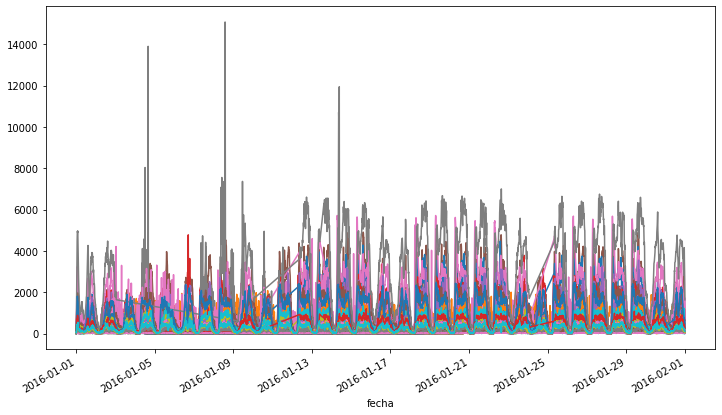

In [22]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes()

for id in selected_traffic_points:
    jan_2016_seleted[jan_2016_seleted["idelem"] == id].plot(x="fecha", y="intensidad", ax=ax)

plt.legend().remove()

plt.show()

In [23]:
measure_inside_mc = jan_2016[jan_2016["idelem"].isin(inside_mc["idelem"])].reset_index(drop=True)
measure_inside_mc

,idelem,fecha,identif,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,4287,2016-01-24 00:30:00,16009,PUNTOS MEDIDA URBANOS,220,52,66,0,N,15
1,3477,2016-01-01 09:15:00,90016,PUNTOS MEDIDA URBANOS,147,1,7,0,N,15
2,4328,2016-01-09 10:00:00,30036,PUNTOS MEDIDA URBANOS,228,8,15,0,N,15
3,4329,2016-01-09 10:00:00,30037,PUNTOS MEDIDA URBANOS,868,3,22,0,N,15
4,7143,2016-01-18 14:30:00,16514,PUNTOS MEDIDA URBANOS,633,19,66,0,N,15
...,...,...,...,...,...,...,...,...,...,...
54524,7095,2016-01-16 19:45:00,97089,PUNTOS MEDIDA URBANOS,758,5,20,0,N,15
54525,4328,2016-01-16 19:45:00,30036,PUNTOS MEDIDA URBANOS,300,12,19,0,N,15
54526,4329,2016-01-16 19:45:00,30037,PUNTOS MEDIDA URBANOS,1056,4,26,0,N,15
54527,6836,2016-01-16 20:00:00,03FL20PM01,PUNTOS MEDIDA M-30,1524,3,0,62,N,5


<AxesSubplot:xlabel='fecha'>

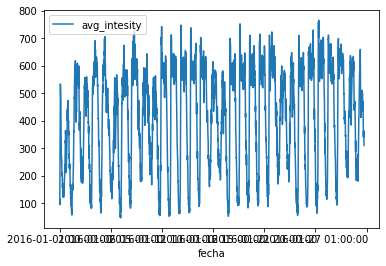

In [24]:
measure_inside_mc.groupby("fecha").agg(avg_intesity=("intensidad", "mean")).plot()

In [25]:
jan_2016_seleted["day"] = jan_2016_seleted["fecha"].dt.day
jan_2016_seleted["month"] = jan_2016_seleted["fecha"].dt.month
jan_2016_seleted["year"] = jan_2016_seleted["fecha"].dt.year

<AxesSubplot:xlabel='date'>

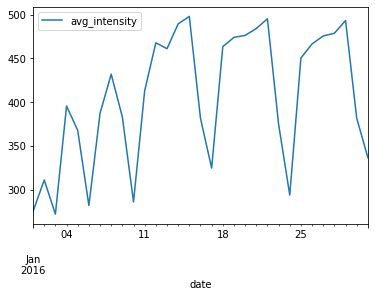

In [26]:
test = jan_2016_seleted.groupby(["day",
                                "month",
                                "year"]).agg(avg_intensity=("intensidad", "mean")).reset_index()

test["date"] = pd.to_datetime(test[["day", "month", "year"]])
test.plot(x="date", y="avg_intensity")

------

Differetn approach

In [27]:
inside_mc = traffic_points[points_in_path_mask]
inside_mc

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y,color
81,4210,495,14014,Meson de Paredes N-S - Miguel Servet-Ronda Val...,440584.032472,4.473281e+06,40.408021,-3.700249,-411909.794639,4.925413e+06,blue
82,4211,495,14015,(AFOROS) Ronda Valencia O-E - Meson de Paredes...,440661.317856,4.473212e+06,40.407410,-3.699331,-411807.695556,4.925324e+06,blue
83,4212,495,14016,Ronda Valencia E-O - Meson de Paredes-Gta. Emb...,440619.045580,4.473206e+06,40.407355,-3.699829,-411863.091077,4.925316e+06,blue
84,4213,495,14017,Embajadores S-N - Sebastian Elcano-Gta. Embaja...,440565.774038,4.473051e+06,40.405948,-3.700442,-411931.356599,4.925110e+06,blue
87,4393,495,18020,San Bernardo N-S - Noviciado-Reyes,440098.333929,4.475396e+06,40.427041,-3.706172,-412569.139993,4.928194e+06,blue
...,...,...,...,...,...,...,...,...,...,...,...
3773,4717,495,90043,Segovia E-O - Cava Baja -Toledo,440033.248880,4.474115e+06,40.415495,-3.706818,-412641.098831,4.926506e+06,blue
3774,3618,495,97042,Don Pedro O-E - Moreria-Bailen,439490.534594,4.473927e+06,40.413765,-3.713197,-413351.157222,4.926253e+06,blue
3775,4263,495,97043,Cra.San Francisco E-O - Isidro Labrador-Gran V...,439646.998594,4.473829e+06,40.412891,-3.711343,-413144.842366,4.926125e+06,blue
3776,4264,495,97044,Gran Vía San Francisco N-S - Cra.San Francisco...,439538.805604,4.473721e+06,40.411913,-3.712608,-413285.647227,4.925982e+06,blue


In [28]:
copy_jan_2016 = jan_2016.copy()

In [29]:
copy_jan_2016["fecha"] = pd.to_datetime(copy_jan_2016["fecha"])

In [30]:
copy_jan_2016["inside_madrid_central"] = False
copy_jan_2016.loc[copy_jan_2016["idelem"].isin(inside_mc["idelem"]), "inside_madrid_central"] = True

In [31]:
copy_jan_2016["day"] = copy_jan_2016["fecha"].dt.day
copy_jan_2016["month"] = copy_jan_2016["fecha"].dt.month
copy_jan_2016["year"] = copy_jan_2016["fecha"].dt.year

In [32]:
copy_jan_2016

,idelem,fecha,identif,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,inside_madrid_central,day,month,year
0,3581,2016-01-01 09:15:00,61079,PUNTOS MEDIDA URBANOS,40,0,0,0,N,1,False,1,1,2016
1,3982,2016-01-01 00:00:00,06042,PUNTOS MEDIDA URBANOS,52,0,2,0,N,13,False,1,1,2016
2,4291,2016-01-01 09:15:00,16013,PUNTOS MEDIDA URBANOS,43,4,12,0,N,7,True,1,1,2016
3,4200,2016-01-01 09:15:00,14002,PUNTOS MEDIDA URBANOS,52,0,4,0,N,14,True,1,1,2016
4,5928,2016-01-01 09:15:00,44030,PUNTOS MEDIDA URBANOS,124,0,6,0,N,13,False,1,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10570677,3788,2016-01-16 20:00:00,75012,PUNTOS MEDIDA URBANOS,182,4,15,0,N,15,False,16,1,2016
10570678,6570,2016-01-16 20:00:00,75013,PUNTOS MEDIDA URBANOS,255,3,12,0,N,15,False,16,1,2016
10570679,6571,2016-01-16 20:00:00,75014,PUNTOS MEDIDA URBANOS,189,3,9,0,N,15,False,16,1,2016
10570680,6572,2016-01-16 20:00:00,75015,PUNTOS MEDIDA URBANOS,163,2,7,0,N,15,False,16,1,2016


<AxesSubplot:xlabel='date'>

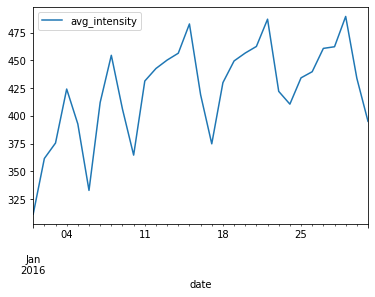

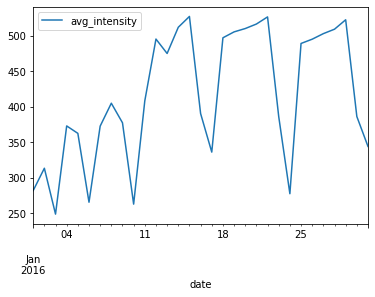

In [33]:
test = copy_jan_2016.groupby(["inside_madrid_central",
                                "day",
                                "month",
                                "year",
                                ]).agg(avg_intensity=("intensidad", "mean")).reset_index()

test["date"] = pd.to_datetime(test[["day", "month", "year"]])
test[test["inside_madrid_central"] == True].plot(x="date", y="avg_intensity")
test[test["inside_madrid_central"] == False].plot(x="date", y="avg_intensity")

# Plot a map with average intensity

Idea: create a grid of points, find the k closest points, and plot accordingly to distance

Create grid

In [34]:
x_min, y_min, x_max, y_max = traffic_points["utm_x"].min(), traffic_points["utm_y"].min(), traffic_points["utm_x"].max(), traffic_points["utm_y"].max()
step = 500

x_points = np.arange(x_min-1000, x_max+1000, step)
y_points = np.arange(y_min-1000, y_max+1000, step)


xs = []
ys = []

for i in range(len(x_points) - 1):
    for j in range(len(y_points) - 1):
        xs.append([x_points[i], x_points[i], x_points[i+1], x_points[i+1]])
        ys.append([y_points[j], y_points[j+1], y_points[j+1], y_points[j]])

In [35]:
p = figure(title="My first interactive plot!", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(traffic_points)
p.circle(x="utm_x", y="utm_y",  size=3, color="color", source=source)

source = ColumnDataSource(g_data)
p.line(x="utm_x", y="utm_y",  color="green", line_width=6, alpha=0.7, source=source)

p.patches(xs, ys, fill_color="red", alpha=0.2)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

show(p)

In [36]:
intensity_per_point = jan_2016.groupby("idelem").agg(intensity_per_point=("intensidad", "mean"))
traffic_points_intesity = pd.merge(traffic_points, intensity_per_point, on="idelem")
traffic_points_intesity

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y,color,intensity_per_point
0,1044,494,03FT08PM01,03FT08PM01,438963.314635,4.474734e+06,40.421001,-3.719488,-414051.481782,4.927311e+06,red,731.360887
1,3600,494,PM30901,PM30901,443729.047369,4.473268e+06,40.408129,-3.663184,-407783.811885,4.925429e+06,red,976.460317
2,3705,494,PM41451,PM41451,439858.261097,4.471574e+06,40.392598,-3.708640,-412843.963659,4.923159e+06,red,1988.587266
3,6823,494,PM41453,PM41453,439188.095183,4.470895e+06,40.386431,-3.716471,-413715.710072,4.922257e+06,red,1116.110224
4,7033,495,01015,Pº Castellana S-N - Pl. Colon-Hermosilla,441569.555897,4.475502e+06,40.428107,-3.688839,-410639.639249,4.928350e+06,red,1034.525481
...,...,...,...,...,...,...,...,...,...,...,...,...
3785,6094,495,47033,Rotonda Nudo Manoteras - Av. Alcalde Conde May...,443873.411055,4.481898e+06,40.485884,-3.662246,-407679.323268,4.936803e+06,red,494.454576
3786,6999,495,55065,Av. Consejo de Europa - Av. Consejo de Europa-...,447857.576632,4.479151e+06,40.461390,-3.615013,-402421.374536,4.933219e+06,red,29.527174
3787,9939,495,87029,(TACTICO) SALIDA BRICOMART,441776.002171,4.468693e+06,40.366783,-3.685782,-410299.414801,4.919386e+06,red,168.980861
3788,5398,495,94017,DOM. PARRAGA O-E(P? FERROV-TRAV. LEGAN),439308.041175,4.466186e+06,40.344022,-3.714610,-413508.524109,4.916061e+06,red,234.021309


In [37]:
traffic_points_intesity["intensity_per_point"].max()

3949.8168734491314

color the grid

1. points in the middle of each grid
2. get clossest value, and draw with that

In [40]:
p = figure(title="My first interactive plot!", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(traffic_points_intesity)
p.circle(x="utm_x", y="utm_y",  size=3, color=linear_cmap("intensity_per_point", "Plasma256", 0, 1000), source=source)

# source = ColumnDataSource(g_data)
# p.line(x="utm_x", y="utm_y",  color="green", line_width=6, alpha=0.7, source=source)

# p.patches(xs, ys, fill_color="red", alpha=0.2)



cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

show(p)